In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import fftpack
import skimage.measure
import scipy.signal

In [2]:
import src.psf as psf
import src.image_helper as image_helper
import src.hyperparams as hyperparams
import src.kernel_estimator as kernel_estimator
import src.deblur as deblur

In [3]:
IMAGE_PATH = 'DIPSourceHW2.png'
RESULT_PATH = './output/'
SIZE = 256
WHITE_LEVEL = 255
ALPHA = 3

To do this exercise, please download the source image DIPSourceHW2.png from here. We
will treat this image as our continuous scene $f (x)$.

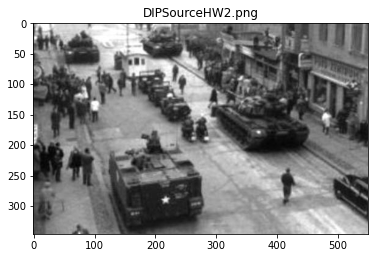

In [4]:
image = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE) 
if (image is None):
    raise Exception(f'image not found at {IMAGE_PATH}')
image = image / WHITE_LEVEL  #normaliztig
image_helper.plot_image(image, f'{IMAGE_PATH}')

Create two high-resolution and two low-resolution versions of the source image, once
using a $sinc$ filter and once using a Gaussian filter. You may choose any $\alpha \in \mathbb{N}$.


In [5]:
psf_service = psf.PSFManager()
print(hyperparams.sinc_hp())
print(hyperparams.gaussian_hp())

{'window_size': 256, 'filter_range': 128}
{'size': 256, 'std': 1}


In [6]:
sinc_psf = psf_service.CreatePSF('sinc',**hyperparams.sinc_hp())
gaussian_psf = psf_service.CreatePSF('gaussian',**hyperparams.gaussian_hp())

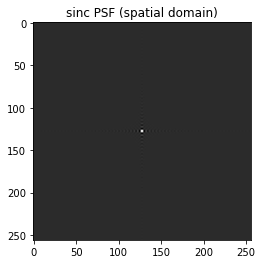

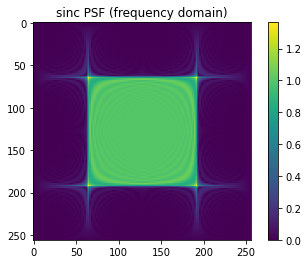

In [7]:
image_helper.plot_psf(sinc_psf,"sinc")

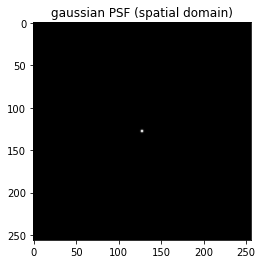

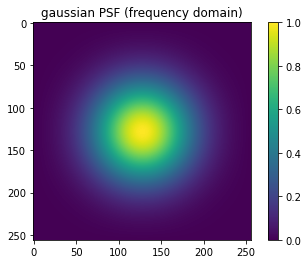

In [8]:
image_helper.plot_psf(gaussian_psf,"gaussian")

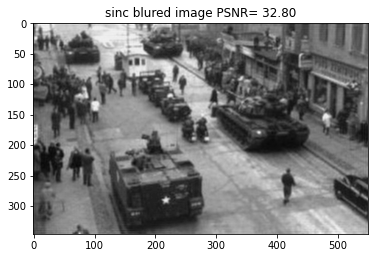

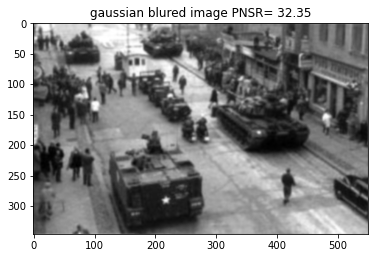

In [9]:
sinc_blured = psf_service.ApplyPSF(image,sinc_psf)
gaussian_blured = psf_service.ApplyPSF(image,gaussian_psf)
image_helper.plot_image(sinc_blured[0],f'sinc blured image PSNR= {sinc_blured[1]:.2f}')
image_helper.plot_image(gaussian_blured[0], f'gaussian blured image PNSR= {gaussian_blured[1]:.2f}')

In [10]:
sinc_estimator = kernel_estimator.KernelEsimator(sinc_blured[0],ALPHA)
gaussian_estimator = kernel_estimator.KernelEsimator(gaussian_blured[0],ALPHA)

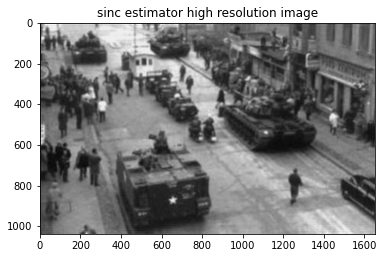

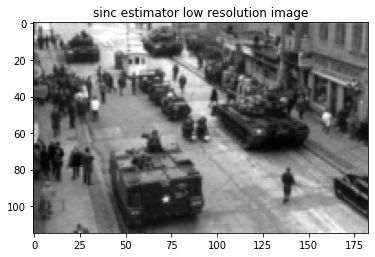

In [11]:
image_helper.plot_image(sinc_estimator.high_resolution_image,f'sinc estimator high resolution image')
image_helper.plot_image(sinc_estimator.low_resolution_image,f'sinc estimator low resolution image')

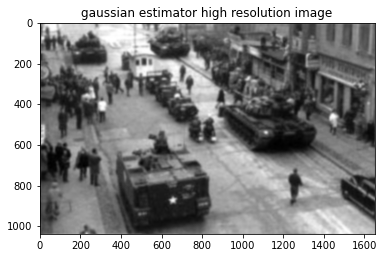

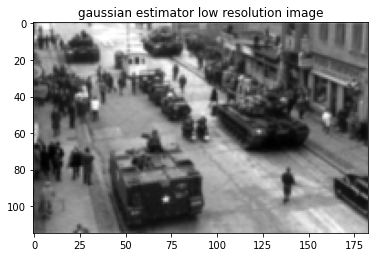

In [12]:
image_helper.plot_image(gaussian_estimator.high_resolution_image,f'gaussian estimator high resolution image')
image_helper.plot_image(gaussian_estimator.low_resolution_image,f'gaussian estimator low resolution image')

Estimate the filters from the downsampled images using the algorithm you have designed.
It is advisable to obtain the largest possible collection of high-resolution patches
$\{p_i\}$, while adopting some of the implementation tricks from NLM in order to improve
complexity. You may not use the high-resolution images in your algorithm.


In [13]:
esimator_hp = hyperparams.esimator_hp()
print(esimator_hp)

{'iterations': 5, 'patch_size': 5, 'reduced_patch_size': 10, 'num_neighbors': 10, 'sigma': 0.3}


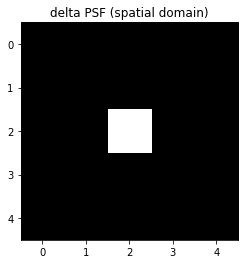

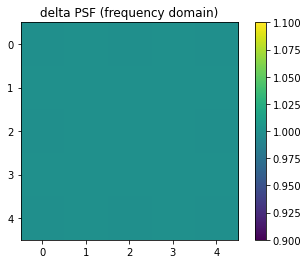

In [14]:
delta = fftpack.fftshift(scipy.signal.unit_impulse((esimator_hp['patch_size'], esimator_hp['patch_size'])))
image_helper.plot_psf(delta,"delta")
guess_k = delta.flatten()

In [14]:
gaussian_estimated_psfs = gaussian_estimator.esimator_kernel(guess_k,**esimator_hp)
sinc_estimated_psfs = sinc_estimator.esimator_kernel(guess_k,**esimator_hp) 
gaussian_estimated_psf = gaussian_estimated_psfs[-1]
sinc_estimated_psf = sinc_estimated_psfs[-1]

TypeError: __generating_Rj__() missing 1 required positional argument: 'patches'

For each of the two recovered kernels, construct two high-resolution images, one from
the low-resolution image the kernel was extracted from, and one from the other lowresolution image.

In [ ]:
debulrService = deblur.DeblurFactory()

In [ ]:
sinc_restored_img_sinc = debulrService.ApplyDeblurFilter('wiener',image=sinc_estimator.low_resolution_image, psf=sinc_estimated_psf)
gaussian_restored_img_gaussian= debulrService.ApplyDeblurFilter('wiener',image=gaussian_estimator.low_resolution_image, psf=gaussian_estimated_psf)

sinc_restored_img_gaussian = debulrService.ApplyDeblurFilter('wiener',image=sinc_estimator.low_resolution_image, psf=gaussian_estimated_psf)
gaussian_restored_img_sinc= debulrService.ApplyDeblurFilter('wiener',image=gaussian_estimator.low_resolution_image, psf=sinc_estimated_psf)

In [ ]:
image_helper.plot_image(sinc_restored_img_sinc,f'sinc restored img with sinc estimator')
image_helper.plot_image(gaussian_restored_img_gaussian,f'gaussian restored img with gaussian estimator')
image_helper.plot_image(sinc_restored_img_gaussian,f'sinc restored img with gaussian estimator')
image_helper.plot_image(gaussian_restored_img_sinc,f'gaussian restored img with sinc estimator')

Evaluate the PSNR for each of the high-resolution images you have obtained.

In [ ]:
print(debulrService.evaluate(sinc_estimator.high_resolution_image,sinc_restored_img_sinc))
print(debulrService.evaluate(gaussian_estimator.high_resolution_image,gaussian_restored_img_gaussian))
print(debulrService.evaluate(sinc_estimator.high_resolution_image,sinc_restored_img_gaussian))
print(debulrService.evaluate(gaussian_estimator.high_resolution_image,gaussian_restored_img_sinc))